<a href="https://colab.research.google.com/github/DivyaMeenaSundaram/Deep_Learning_Lab/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📌 STEP 1: Imports and Setup
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
# 📌 STEP 2: Mount Drive and Transform
from google.colab import drive
drive.mount('/content/drive')

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

Mounted at /content/drive


In [8]:
import os

root_dir = '/content/drive/MyDrive/Pneumonia dataset/chest_xray'

for folder in os.listdir(root_dir):
    print(f"Folder: {folder}")
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):
        print("Sample files:", os.listdir(folder_path)[:5])
    else:
        print("Not a directory!")


Folder: val
Sample files: ['NORMAL', 'PNEUMONIA']
Folder: train
Sample files: ['PNEUMONIA', 'NORMAL']
Folder: test
Sample files: ['PNEUMONIA', 'NORMAL']


In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset_path = '/content/drive/MyDrive/Pneumonia dataset/chest_xray/train'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print("Classes:", dataset.classes)
print("Number of images:", len(dataset))

Classes: ['NORMAL', 'PNEUMONIA']
Number of images: 3610


In [11]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_names = sorted(os.listdir(root_dir))  # read all folder names
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}

        for class_name in self.class_names:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            for file in os.listdir(class_dir):
                if file.lower().endswith(('.jpeg', '.jpg', '.png')):
                    self.image_paths.append(os.path.join(class_dir, file))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


dataset_path = '/content/drive/MyDrive/Pneumonia dataset/chest_xray/train'

dataset = ChestXrayDataset(dataset_path, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

num_classes = len(dataset.class_names)
print("Loaded dataset with", len(dataset), "samples")
print("Classes:", dataset.class_names)

Loaded dataset with 3610 samples
Classes: ['NORMAL', 'PNEUMONIA']


In [12]:
# 📌 STEP 4: Conditional Generator
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, num_classes):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, z_dim)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, 4, 1, 0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),     # 4x4 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),      # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),       # 16x16 -> 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, img_channels, 4, 2, 1, bias=False),  # 32x32 -> 64x64
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embed = self.label_embed(labels).unsqueeze(2).unsqueeze(3)  # [B, z_dim, 1, 1]
        x = noise + label_embed  # Combine label and noise
        return self.net(x)

In [13]:
# 📌 STEP 5: Conditional Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels, num_classes):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, 64 * 64)
        self.net = nn.Sequential(
            nn.Conv2d(2, 32, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 8),  # Output 1x1
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_map = self.label_embed(labels).view(labels.size(0), 1, 64, 64)
        x = torch.cat([img, label_map], dim=1)  # Concatenate channel-wise
        return self.net(x)

In [14]:
# 📌 STEP 6: Instantiate Models, Loss, Optimizers
num_classes = 2  # set this before model instantiation
z_dim = 100
G = Generator(z_dim, img_channels=1, num_classes=num_classes).to(device)
D = Discriminator(img_channels=1, num_classes=num_classes).to(device)

criterion = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(16, z_dim, 1, 1).to(device)
fixed_labels = torch.tensor([i % num_classes for i in range(16)], device=device)


[Epoch 0] D_loss: 1.5092 | G_loss: 1.4658


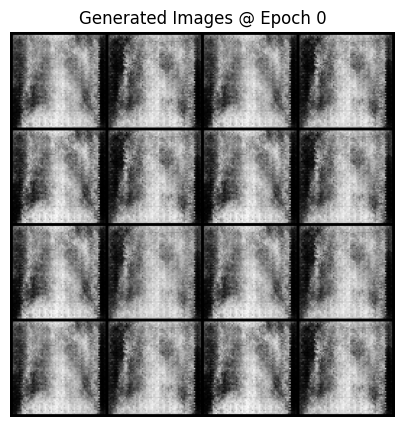

[Epoch 10] D_loss: 0.9542 | G_loss: 1.3172


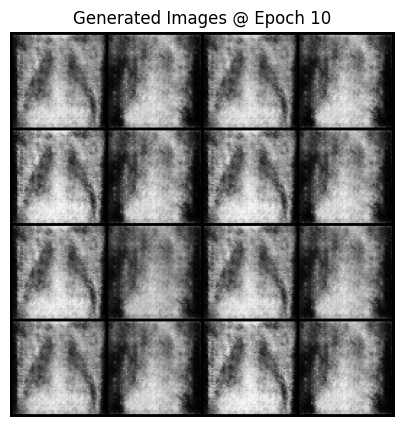

[Epoch 20] D_loss: 0.7326 | G_loss: 2.3041


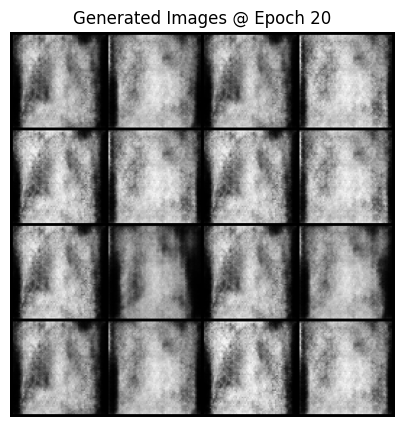

[Epoch 30] D_loss: 1.1259 | G_loss: 1.7320


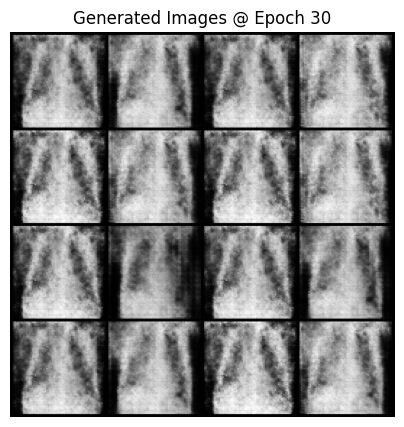

[Epoch 40] D_loss: 1.0319 | G_loss: 2.0233


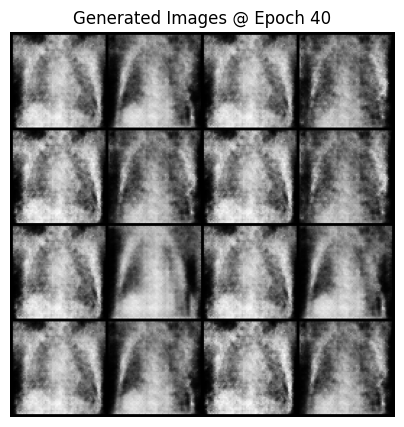

In [ ]:
# 📌 STEP 7: Training Loop
epochs = 100
for epoch in range(epochs):
    for real_imgs, labels in dataloader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        # === Train Discriminator ===
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_imgs = G(noise, labels)

        D_real = D(real_imgs, labels).view(-1)
        D_fake = D(fake_imgs.detach(), labels).view(-1)

        real_targets = torch.ones_like(D_real)
        fake_targets = torch.zeros_like(D_fake)

        D_loss_real = criterion(D_real, real_targets)
        D_loss_fake = criterion(D_fake, fake_targets)
        D_loss = D_loss_real + D_loss_fake

        opt_D.zero_grad()
        D_loss.backward()
        opt_D.step()

        # === Train Generator ===
        output = D(fake_imgs, labels).view(-1)
        G_loss = criterion(output, real_targets)

        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()

    # === Logging and Visualization ===
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"[Epoch {epoch}] D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")
        with torch.no_grad():
            fake = G(fixed_noise, fixed_labels).detach().cpu()
        grid = utils.make_grid(fake, nrow=4, normalize=True)
        plt.figure(figsize=(5, 5))
        plt.imshow(np.transpose(grid, (1, 2, 0)), cmap='gray')
        plt.title(f"Generated Images @ Epoch {epoch}")
        plt.axis("off")
        plt.show()
